# Neural Network model
- recognize the digit using pixel value
- use PyTorch

## Import the libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# use cuda to accelerate the computations
# cuda ultlizes the GPU to acceleate the computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Datasets
- train.csv for building the model
- test.csv for making a prediction to Kaggle 

In [3]:
df_train = pd.DataFrame(pd.read_csv('train.csv'))
df_test = pd.DataFrame(pd.read_csv('test.csv'))

In [4]:
df_train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Understand and visualize the dataset

### The unique digit in the dataset

In [5]:
unique_values = df_train['label'].unique()
unique_values.sort()
print(unique_values)

[0 1 2 3 4 5 6 7 8 9]


### The distribution of the label in the dataset
- the distribution is roughly uniform

<AxesSubplot:ylabel='Frequency'>

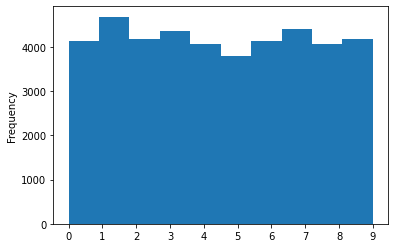

In [6]:
df_train['label'].plot.hist(bins=10, xticks=unique_values)

In [7]:
df_train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

## Building model using PyTorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Split the data into label (target class) and training set

In [9]:
y = df_train['label']
X = df_train.drop('label', axis=1)
# random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Use MinMaxScaler to normalize data
- the digit label doesn't need to be normalized since it's the target class
- normalize the pixel values

In [10]:
scaler = MinMaxScaler()
# reference: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
# the fit_transform method always used on training data
# the purpose is to calculate the mean and variance of each of the features
X_train = scaler.fit_transform(X_train)
# the transform method uses the calculated mean and variance
# to transform the test data

# the label doesn't need to be normalized -> it's the digit class
X_test = scaler.fit_transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
# ensure the correct data shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((33600, 784), (8400, 784), (33600,), (8400,))

### Following the tutorial
reference: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [12]:
class ClassifierDataset(Dataset):
  """ Inherit the torch Dataset class to be modularized
      Keep the necessary data for model training.
      The training set needs to be (float, long) type.
  """
  def __init__(self, X_data, y_data):
    super(ClassifierDataset, self).__init__()
    self.X_data = X_data
    self.y_data = y_data
      
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
      
  def __len__ (self):
    return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Define and optimize the model
- specify the parameters
- specify optimization model and learning rate
- see whether more layers or nodes per layer improve the performance
  - reference: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [83]:
EPOCHS = 150 # more epochs to train the model more times
BATCH_SIZE = 16 # each time the size of the training data brought in the model
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns) # the optimal size of the hidden layer is between the features and the classes
NUM_CLASSES = 10 # the unique numbers from 0 to 9

In [84]:
# training loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader

In [85]:
# validation loader
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

### Simple 3-layer feed-forward network
- with drop and batch-norm

In [86]:
class MulticlassClassification(nn.Module):
    """ The simple three layer multi-classification class
    
    """
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.layer_out(x)
        
        return x

In [87]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Specify the optimizer

In [88]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### The model description

In [89]:
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the model

In [90]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
  
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  
  acc = torch.round(acc * 100)
  
  return acc

In [91]:
# the dictionary for saving the data to plot and check whether the model underfits or overfitss
accuracy_stats = {
  'train': [],
  "val": []
}
loss_stats = {
  'train': [],
  "val": []
}

In [92]:
# reference: https://stackoverflow.com/questions/54374935/how-to-fix-this-strange-error-runtimeerror-cuda-error-out-of-memory
# collect the GPU memory to train the model if using CUDA
import gc
gc.collect()

torch.cuda.empty_cache()

### Training process

In [93]:
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  1%|          | 1/150 [01:25<3:33:03, 85.79s/it]

Epoch 001: | Train Loss: 0.54204 | Val Loss: 0.17885 | Train Acc: 84.450| Val Acc: 94.690


  1%|▏         | 2/150 [02:34<3:07:00, 75.81s/it]

Epoch 002: | Train Loss: 0.32000 | Val Loss: 0.13543 | Train Acc: 90.297| Val Acc: 96.071


  2%|▏         | 3/150 [03:51<3:06:28, 76.11s/it]

Epoch 003: | Train Loss: 0.27561 | Val Loss: 0.11505 | Train Acc: 91.760| Val Acc: 96.536


  3%|▎         | 4/150 [04:45<2:44:09, 67.46s/it]

Epoch 004: | Train Loss: 0.24625 | Val Loss: 0.10624 | Train Acc: 92.704| Val Acc: 96.690


  3%|▎         | 5/150 [05:34<2:27:02, 60.85s/it]

Epoch 005: | Train Loss: 0.21894 | Val Loss: 0.10302 | Train Acc: 93.282| Val Acc: 97.024


  4%|▍         | 6/150 [06:34<2:25:48, 60.76s/it]

Epoch 006: | Train Loss: 0.20660 | Val Loss: 0.08762 | Train Acc: 93.792| Val Acc: 97.131


  5%|▍         | 7/150 [07:19<2:12:27, 55.58s/it]

Epoch 007: | Train Loss: 0.18626 | Val Loss: 0.09573 | Train Acc: 94.413| Val Acc: 97.048


  5%|▌         | 8/150 [08:08<2:06:24, 53.41s/it]

Epoch 008: | Train Loss: 0.17645 | Val Loss: 0.08483 | Train Acc: 94.539| Val Acc: 97.250


  6%|▌         | 9/150 [08:46<1:54:24, 48.68s/it]

Epoch 009: | Train Loss: 0.16947 | Val Loss: 0.08511 | Train Acc: 94.920| Val Acc: 97.226


  7%|▋         | 10/150 [09:23<1:44:44, 44.89s/it]

Epoch 010: | Train Loss: 0.16397 | Val Loss: 0.07820 | Train Acc: 95.044| Val Acc: 97.595


  7%|▋         | 11/150 [10:06<1:42:31, 44.25s/it]

Epoch 011: | Train Loss: 0.15893 | Val Loss: 0.07388 | Train Acc: 95.263| Val Acc: 97.631


  8%|▊         | 12/150 [10:45<1:38:02, 42.63s/it]

Epoch 012: | Train Loss: 0.15355 | Val Loss: 0.07196 | Train Acc: 95.448| Val Acc: 97.786


  9%|▊         | 13/150 [11:52<1:54:43, 50.24s/it]

Epoch 013: | Train Loss: 0.14940 | Val Loss: 0.07237 | Train Acc: 95.527| Val Acc: 97.619


  9%|▉         | 14/150 [12:35<1:48:41, 47.95s/it]

Epoch 014: | Train Loss: 0.14000 | Val Loss: 0.06909 | Train Acc: 95.750| Val Acc: 97.738


 10%|█         | 15/150 [13:23<1:47:46, 47.90s/it]

Epoch 015: | Train Loss: 0.13453 | Val Loss: 0.06854 | Train Acc: 95.860| Val Acc: 97.786


 11%|█         | 16/150 [14:12<1:47:52, 48.30s/it]

Epoch 016: | Train Loss: 0.13363 | Val Loss: 0.06723 | Train Acc: 95.881| Val Acc: 97.810


 11%|█▏        | 17/150 [14:58<1:45:22, 47.54s/it]

Epoch 017: | Train Loss: 0.12595 | Val Loss: 0.06941 | Train Acc: 96.253| Val Acc: 97.690


 12%|█▏        | 18/150 [15:42<1:42:35, 46.63s/it]

Epoch 018: | Train Loss: 0.12395 | Val Loss: 0.06878 | Train Acc: 96.228| Val Acc: 97.833


 13%|█▎        | 19/150 [16:26<1:39:35, 45.61s/it]

Epoch 019: | Train Loss: 0.12065 | Val Loss: 0.06535 | Train Acc: 96.470| Val Acc: 97.893


 13%|█▎        | 20/150 [17:05<1:34:52, 43.79s/it]

Epoch 020: | Train Loss: 0.11739 | Val Loss: 0.06460 | Train Acc: 96.343| Val Acc: 97.869


 14%|█▍        | 21/150 [17:49<1:34:06, 43.77s/it]

Epoch 021: | Train Loss: 0.11641 | Val Loss: 0.06709 | Train Acc: 96.423| Val Acc: 97.714


 15%|█▍        | 22/150 [18:28<1:30:21, 42.36s/it]

Epoch 022: | Train Loss: 0.11095 | Val Loss: 0.06167 | Train Acc: 96.588| Val Acc: 98.060


 15%|█▌        | 23/150 [19:18<1:34:22, 44.59s/it]

Epoch 023: | Train Loss: 0.11331 | Val Loss: 0.06546 | Train Acc: 96.440| Val Acc: 97.821


 16%|█▌        | 24/150 [20:11<1:39:17, 47.28s/it]

Epoch 024: | Train Loss: 0.11232 | Val Loss: 0.06322 | Train Acc: 96.539| Val Acc: 97.845


 17%|█▋        | 25/150 [20:44<1:29:30, 42.96s/it]

Epoch 025: | Train Loss: 0.10777 | Val Loss: 0.06200 | Train Acc: 96.726| Val Acc: 97.988


 17%|█▋        | 26/150 [21:31<1:31:08, 44.10s/it]

Epoch 026: | Train Loss: 0.10706 | Val Loss: 0.06396 | Train Acc: 96.649| Val Acc: 97.881


 18%|█▊        | 27/150 [22:12<1:28:18, 43.07s/it]

Epoch 027: | Train Loss: 0.09925 | Val Loss: 0.05839 | Train Acc: 97.067| Val Acc: 98.119


 19%|█▊        | 28/150 [22:52<1:26:09, 42.37s/it]

Epoch 028: | Train Loss: 0.10262 | Val Loss: 0.05890 | Train Acc: 96.972| Val Acc: 98.107


 19%|█▉        | 29/150 [23:40<1:28:41, 43.98s/it]

Epoch 029: | Train Loss: 0.10364 | Val Loss: 0.05820 | Train Acc: 96.792| Val Acc: 97.917


 20%|██        | 30/150 [24:25<1:28:16, 44.14s/it]

Epoch 030: | Train Loss: 0.09783 | Val Loss: 0.05848 | Train Acc: 97.060| Val Acc: 98.048


 21%|██        | 31/150 [24:57<1:20:48, 40.75s/it]

Epoch 031: | Train Loss: 0.09657 | Val Loss: 0.05627 | Train Acc: 97.046| Val Acc: 98.214


 21%|██▏       | 32/150 [25:30<1:15:18, 38.29s/it]

Epoch 032: | Train Loss: 0.09162 | Val Loss: 0.05693 | Train Acc: 97.184| Val Acc: 98.131


 22%|██▏       | 33/150 [26:01<1:10:27, 36.13s/it]

Epoch 033: | Train Loss: 0.09259 | Val Loss: 0.05863 | Train Acc: 97.210| Val Acc: 98.190


 23%|██▎       | 34/150 [26:31<1:06:04, 34.17s/it]

Epoch 034: | Train Loss: 0.08970 | Val Loss: 0.06091 | Train Acc: 97.283| Val Acc: 98.155


 23%|██▎       | 35/150 [27:00<1:02:54, 32.82s/it]

Epoch 035: | Train Loss: 0.09139 | Val Loss: 0.05651 | Train Acc: 97.074| Val Acc: 98.238


 24%|██▍       | 36/150 [27:30<1:00:32, 31.86s/it]

Epoch 036: | Train Loss: 0.09008 | Val Loss: 0.05491 | Train Acc: 97.295| Val Acc: 98.202


 25%|██▍       | 37/150 [27:59<58:41, 31.17s/it]  

Epoch 037: | Train Loss: 0.08919 | Val Loss: 0.05635 | Train Acc: 97.179| Val Acc: 98.262


 25%|██▌       | 38/150 [28:29<57:15, 30.67s/it]

Epoch 038: | Train Loss: 0.09056 | Val Loss: 0.05407 | Train Acc: 97.280| Val Acc: 98.238


 26%|██▌       | 39/150 [29:03<58:35, 31.67s/it]

Epoch 039: | Train Loss: 0.08366 | Val Loss: 0.06047 | Train Acc: 97.473| Val Acc: 98.214


 27%|██▋       | 40/150 [29:34<57:42, 31.48s/it]

Epoch 040: | Train Loss: 0.08776 | Val Loss: 0.05569 | Train Acc: 97.254| Val Acc: 98.250


 27%|██▋       | 41/150 [30:05<56:49, 31.28s/it]

Epoch 041: | Train Loss: 0.08322 | Val Loss: 0.06007 | Train Acc: 97.378| Val Acc: 98.167


 28%|██▊       | 42/150 [30:35<55:55, 31.07s/it]

Epoch 042: | Train Loss: 0.08125 | Val Loss: 0.06202 | Train Acc: 97.464| Val Acc: 98.012


 29%|██▊       | 43/150 [31:06<55:21, 31.04s/it]

Epoch 043: | Train Loss: 0.08080 | Val Loss: 0.05448 | Train Acc: 97.525| Val Acc: 98.298


 29%|██▉       | 44/150 [31:37<54:38, 30.93s/it]

Epoch 044: | Train Loss: 0.08165 | Val Loss: 0.06125 | Train Acc: 97.485| Val Acc: 97.976


 30%|███       | 45/150 [32:08<54:08, 30.94s/it]

Epoch 045: | Train Loss: 0.08057 | Val Loss: 0.05931 | Train Acc: 97.540| Val Acc: 98.190


 31%|███       | 46/150 [32:39<53:25, 30.82s/it]

Epoch 046: | Train Loss: 0.08386 | Val Loss: 0.05789 | Train Acc: 97.517| Val Acc: 98.131


 31%|███▏      | 47/150 [33:10<53:17, 31.04s/it]

Epoch 047: | Train Loss: 0.07752 | Val Loss: 0.06165 | Train Acc: 97.592| Val Acc: 98.131


 32%|███▏      | 48/150 [33:41<52:40, 30.99s/it]

Epoch 048: | Train Loss: 0.08126 | Val Loss: 0.05983 | Train Acc: 97.445| Val Acc: 98.202


 33%|███▎      | 49/150 [34:12<52:04, 30.93s/it]

Epoch 049: | Train Loss: 0.07894 | Val Loss: 0.05658 | Train Acc: 97.565| Val Acc: 98.179


 33%|███▎      | 50/150 [34:43<51:28, 30.88s/it]

Epoch 050: | Train Loss: 0.07246 | Val Loss: 0.05836 | Train Acc: 97.758| Val Acc: 98.250


 34%|███▍      | 51/150 [35:13<50:48, 30.80s/it]

Epoch 051: | Train Loss: 0.07434 | Val Loss: 0.05872 | Train Acc: 97.746| Val Acc: 98.190


 35%|███▍      | 52/150 [35:44<50:19, 30.82s/it]

Epoch 052: | Train Loss: 0.07784 | Val Loss: 0.06135 | Train Acc: 97.656| Val Acc: 98.214


 35%|███▌      | 53/150 [36:15<49:56, 30.89s/it]

Epoch 053: | Train Loss: 0.08045 | Val Loss: 0.05988 | Train Acc: 97.524| Val Acc: 98.155


 36%|███▌      | 54/150 [36:46<49:23, 30.87s/it]

Epoch 054: | Train Loss: 0.07309 | Val Loss: 0.05809 | Train Acc: 97.695| Val Acc: 98.298


 37%|███▋      | 55/150 [37:16<48:42, 30.76s/it]

Epoch 055: | Train Loss: 0.07133 | Val Loss: 0.06325 | Train Acc: 97.910| Val Acc: 98.190


 37%|███▋      | 56/150 [37:47<48:12, 30.77s/it]

Epoch 056: | Train Loss: 0.07409 | Val Loss: 0.05694 | Train Acc: 97.732| Val Acc: 98.321


 38%|███▊      | 57/150 [38:19<48:04, 31.01s/it]

Epoch 057: | Train Loss: 0.07360 | Val Loss: 0.05815 | Train Acc: 97.680| Val Acc: 98.321


 39%|███▊      | 58/150 [38:50<47:33, 31.02s/it]

Epoch 058: | Train Loss: 0.07510 | Val Loss: 0.05861 | Train Acc: 97.693| Val Acc: 98.155


 39%|███▉      | 59/150 [39:20<46:48, 30.86s/it]

Epoch 059: | Train Loss: 0.07065 | Val Loss: 0.05761 | Train Acc: 97.744| Val Acc: 98.274


 40%|████      | 60/150 [39:51<46:19, 30.88s/it]

Epoch 060: | Train Loss: 0.06617 | Val Loss: 0.05986 | Train Acc: 97.870| Val Acc: 98.226


 41%|████      | 61/150 [40:22<45:40, 30.79s/it]

Epoch 061: | Train Loss: 0.07293 | Val Loss: 0.05851 | Train Acc: 97.741| Val Acc: 98.321


 41%|████▏     | 62/150 [40:53<45:31, 31.04s/it]

Epoch 062: | Train Loss: 0.06796 | Val Loss: 0.05828 | Train Acc: 97.920| Val Acc: 98.238


 42%|████▏     | 63/150 [41:25<45:11, 31.17s/it]

Epoch 063: | Train Loss: 0.06727 | Val Loss: 0.05680 | Train Acc: 97.869| Val Acc: 98.357


 43%|████▎     | 64/150 [41:56<44:36, 31.12s/it]

Epoch 064: | Train Loss: 0.07085 | Val Loss: 0.06220 | Train Acc: 97.855| Val Acc: 98.036


 43%|████▎     | 65/150 [42:27<43:55, 31.01s/it]

Epoch 065: | Train Loss: 0.06948 | Val Loss: 0.05547 | Train Acc: 97.864| Val Acc: 98.286


 44%|████▍     | 66/150 [42:58<43:21, 30.98s/it]

Epoch 066: | Train Loss: 0.06514 | Val Loss: 0.05269 | Train Acc: 97.951| Val Acc: 98.274


 45%|████▍     | 67/150 [43:29<43:11, 31.22s/it]

Epoch 067: | Train Loss: 0.06543 | Val Loss: 0.06192 | Train Acc: 97.992| Val Acc: 98.226


 45%|████▌     | 68/150 [44:00<42:38, 31.20s/it]

Epoch 068: | Train Loss: 0.06873 | Val Loss: 0.05635 | Train Acc: 97.914| Val Acc: 98.369


 46%|████▌     | 69/150 [44:32<42:07, 31.21s/it]

Epoch 069: | Train Loss: 0.06561 | Val Loss: 0.05835 | Train Acc: 97.929| Val Acc: 98.274


 47%|████▋     | 70/150 [45:03<41:28, 31.10s/it]

Epoch 070: | Train Loss: 0.06828 | Val Loss: 0.05847 | Train Acc: 97.878| Val Acc: 98.214


 47%|████▋     | 71/150 [45:33<40:41, 30.90s/it]

Epoch 071: | Train Loss: 0.06580 | Val Loss: 0.05826 | Train Acc: 97.911| Val Acc: 98.298


 48%|████▊     | 72/150 [46:04<40:05, 30.84s/it]

Epoch 072: | Train Loss: 0.06069 | Val Loss: 0.05790 | Train Acc: 98.085| Val Acc: 98.202


 49%|████▊     | 73/150 [46:34<39:30, 30.78s/it]

Epoch 073: | Train Loss: 0.06473 | Val Loss: 0.05776 | Train Acc: 98.060| Val Acc: 98.190


 49%|████▉     | 74/150 [47:06<39:13, 30.96s/it]

Epoch 074: | Train Loss: 0.06484 | Val Loss: 0.05876 | Train Acc: 97.915| Val Acc: 98.155


 50%|█████     | 75/150 [47:36<38:30, 30.81s/it]

Epoch 075: | Train Loss: 0.06799 | Val Loss: 0.05488 | Train Acc: 97.823| Val Acc: 98.250


 51%|█████     | 76/150 [48:10<38:58, 31.60s/it]

Epoch 076: | Train Loss: 0.06389 | Val Loss: 0.05739 | Train Acc: 97.988| Val Acc: 98.369


 51%|█████▏    | 77/150 [48:41<38:20, 31.51s/it]

Epoch 077: | Train Loss: 0.06318 | Val Loss: 0.05883 | Train Acc: 98.096| Val Acc: 98.119


 52%|█████▏    | 78/150 [49:12<37:35, 31.32s/it]

Epoch 078: | Train Loss: 0.05908 | Val Loss: 0.05926 | Train Acc: 98.137| Val Acc: 98.238


 53%|█████▎    | 79/150 [49:43<36:54, 31.19s/it]

Epoch 079: | Train Loss: 0.06444 | Val Loss: 0.05916 | Train Acc: 98.123| Val Acc: 98.167


 53%|█████▎    | 80/150 [50:14<36:19, 31.13s/it]

Epoch 080: | Train Loss: 0.06189 | Val Loss: 0.06237 | Train Acc: 98.105| Val Acc: 98.024


 54%|█████▍    | 81/150 [50:45<35:43, 31.07s/it]

Epoch 081: | Train Loss: 0.06125 | Val Loss: 0.05673 | Train Acc: 98.068| Val Acc: 98.369


 55%|█████▍    | 82/150 [51:16<35:09, 31.02s/it]

Epoch 082: | Train Loss: 0.06138 | Val Loss: 0.05856 | Train Acc: 98.004| Val Acc: 98.274


 55%|█████▌    | 83/150 [51:47<34:38, 31.02s/it]

Epoch 083: | Train Loss: 0.05978 | Val Loss: 0.05280 | Train Acc: 98.084| Val Acc: 98.405


 56%|█████▌    | 84/150 [52:17<34:04, 30.97s/it]

Epoch 084: | Train Loss: 0.05775 | Val Loss: 0.05760 | Train Acc: 98.071| Val Acc: 98.345


 57%|█████▋    | 85/150 [52:48<33:29, 30.92s/it]

Epoch 085: | Train Loss: 0.05831 | Val Loss: 0.05615 | Train Acc: 98.143| Val Acc: 98.298


 57%|█████▋    | 86/150 [53:20<33:20, 31.25s/it]

Epoch 086: | Train Loss: 0.05960 | Val Loss: 0.05933 | Train Acc: 98.176| Val Acc: 98.238


 58%|█████▊    | 87/150 [53:51<32:42, 31.16s/it]

Epoch 087: | Train Loss: 0.05969 | Val Loss: 0.06319 | Train Acc: 98.191| Val Acc: 98.179


 59%|█████▊    | 88/150 [54:22<32:08, 31.10s/it]

Epoch 088: | Train Loss: 0.06039 | Val Loss: 0.05761 | Train Acc: 98.107| Val Acc: 98.369


 59%|█████▉    | 89/150 [54:53<31:32, 31.02s/it]

Epoch 089: | Train Loss: 0.05622 | Val Loss: 0.05675 | Train Acc: 98.185| Val Acc: 98.321


 60%|██████    | 90/150 [55:24<30:55, 30.92s/it]

Epoch 090: | Train Loss: 0.05656 | Val Loss: 0.05505 | Train Acc: 98.261| Val Acc: 98.298


 61%|██████    | 91/150 [55:55<30:27, 30.97s/it]

Epoch 091: | Train Loss: 0.06121 | Val Loss: 0.05643 | Train Acc: 98.064| Val Acc: 98.333


 61%|██████▏   | 92/150 [56:26<29:57, 30.99s/it]

Epoch 092: | Train Loss: 0.05798 | Val Loss: 0.05601 | Train Acc: 98.176| Val Acc: 98.274


 62%|██████▏   | 93/150 [56:56<29:20, 30.88s/it]

Epoch 093: | Train Loss: 0.05723 | Val Loss: 0.05808 | Train Acc: 98.063| Val Acc: 98.298


 63%|██████▎   | 94/150 [57:28<28:55, 30.99s/it]

Epoch 094: | Train Loss: 0.05628 | Val Loss: 0.06024 | Train Acc: 98.244| Val Acc: 98.333


 63%|██████▎   | 95/150 [57:58<28:19, 30.90s/it]

Epoch 095: | Train Loss: 0.06142 | Val Loss: 0.05471 | Train Acc: 98.077| Val Acc: 98.333


 64%|██████▍   | 96/150 [58:30<27:59, 31.10s/it]

Epoch 096: | Train Loss: 0.05749 | Val Loss: 0.05543 | Train Acc: 98.200| Val Acc: 98.321


 65%|██████▍   | 97/150 [59:01<27:28, 31.10s/it]

Epoch 097: | Train Loss: 0.05817 | Val Loss: 0.05708 | Train Acc: 98.180| Val Acc: 98.333


 65%|██████▌   | 98/150 [59:32<26:57, 31.10s/it]

Epoch 098: | Train Loss: 0.05862 | Val Loss: 0.05491 | Train Acc: 98.211| Val Acc: 98.286


 66%|██████▌   | 99/150 [1:00:03<26:22, 31.02s/it]

Epoch 099: | Train Loss: 0.05401 | Val Loss: 0.05948 | Train Acc: 98.313| Val Acc: 98.238


 67%|██████▋   | 100/150 [1:00:38<26:58, 32.38s/it]

Epoch 100: | Train Loss: 0.05507 | Val Loss: 0.06259 | Train Acc: 98.370| Val Acc: 98.107


 67%|██████▋   | 101/150 [1:01:21<28:59, 35.51s/it]

Epoch 101: | Train Loss: 0.05277 | Val Loss: 0.05863 | Train Acc: 98.397| Val Acc: 98.226


 68%|██████▊   | 102/150 [1:02:00<29:08, 36.43s/it]

Epoch 102: | Train Loss: 0.05341 | Val Loss: 0.06136 | Train Acc: 98.284| Val Acc: 98.238


 69%|██████▊   | 103/150 [1:02:32<27:38, 35.28s/it]

Epoch 103: | Train Loss: 0.05589 | Val Loss: 0.05669 | Train Acc: 98.218| Val Acc: 98.345


 69%|██████▉   | 104/150 [1:03:06<26:33, 34.63s/it]

Epoch 104: | Train Loss: 0.05777 | Val Loss: 0.05948 | Train Acc: 98.250| Val Acc: 98.262


 70%|███████   | 105/150 [1:03:43<26:39, 35.55s/it]

Epoch 105: | Train Loss: 0.05551 | Val Loss: 0.05750 | Train Acc: 98.270| Val Acc: 98.333


 71%|███████   | 106/150 [1:04:14<24:58, 34.06s/it]

Epoch 106: | Train Loss: 0.05300 | Val Loss: 0.06078 | Train Acc: 98.351| Val Acc: 98.274


 71%|███████▏  | 107/150 [1:04:45<23:41, 33.05s/it]

Epoch 107: | Train Loss: 0.05280 | Val Loss: 0.05472 | Train Acc: 98.372| Val Acc: 98.321


 72%|███████▏  | 108/150 [1:05:17<22:59, 32.84s/it]

Epoch 108: | Train Loss: 0.05159 | Val Loss: 0.05831 | Train Acc: 98.395| Val Acc: 98.202


 73%|███████▎  | 109/150 [1:05:48<22:05, 32.33s/it]

Epoch 109: | Train Loss: 0.05483 | Val Loss: 0.05349 | Train Acc: 98.321| Val Acc: 98.286


 73%|███████▎  | 110/150 [1:06:19<21:15, 31.89s/it]

Epoch 110: | Train Loss: 0.05210 | Val Loss: 0.05547 | Train Acc: 98.365| Val Acc: 98.357


 74%|███████▍  | 111/150 [1:06:49<20:24, 31.39s/it]

Epoch 111: | Train Loss: 0.05284 | Val Loss: 0.05313 | Train Acc: 98.264| Val Acc: 98.310


 75%|███████▍  | 112/150 [1:07:20<19:45, 31.20s/it]

Epoch 112: | Train Loss: 0.05315 | Val Loss: 0.05317 | Train Acc: 98.339| Val Acc: 98.298


 75%|███████▌  | 113/150 [1:07:50<19:03, 30.90s/it]

Epoch 113: | Train Loss: 0.05230 | Val Loss: 0.05193 | Train Acc: 98.313| Val Acc: 98.405


 76%|███████▌  | 114/150 [1:08:21<18:32, 30.91s/it]

Epoch 114: | Train Loss: 0.04931 | Val Loss: 0.05740 | Train Acc: 98.495| Val Acc: 98.298


 77%|███████▋  | 115/150 [1:08:52<18:00, 30.86s/it]

Epoch 115: | Train Loss: 0.04972 | Val Loss: 0.05455 | Train Acc: 98.443| Val Acc: 98.452


 77%|███████▋  | 116/150 [1:09:22<17:25, 30.75s/it]

Epoch 116: | Train Loss: 0.05320 | Val Loss: 0.05307 | Train Acc: 98.296| Val Acc: 98.429


 78%|███████▊  | 117/150 [1:09:52<16:46, 30.49s/it]

Epoch 117: | Train Loss: 0.05077 | Val Loss: 0.05691 | Train Acc: 98.429| Val Acc: 98.214


 79%|███████▊  | 118/150 [1:10:23<16:15, 30.48s/it]

Epoch 118: | Train Loss: 0.05049 | Val Loss: 0.05393 | Train Acc: 98.373| Val Acc: 98.405


 79%|███████▉  | 119/150 [1:10:53<15:42, 30.40s/it]

Epoch 119: | Train Loss: 0.05056 | Val Loss: 0.05209 | Train Acc: 98.327| Val Acc: 98.429


 80%|████████  | 120/150 [1:11:28<15:53, 31.78s/it]

Epoch 120: | Train Loss: 0.04937 | Val Loss: 0.05446 | Train Acc: 98.474| Val Acc: 98.417


 81%|████████  | 121/150 [1:11:59<15:12, 31.46s/it]

Epoch 121: | Train Loss: 0.05221 | Val Loss: 0.05264 | Train Acc: 98.392| Val Acc: 98.381


 81%|████████▏ | 122/150 [1:12:31<14:51, 31.85s/it]

Epoch 122: | Train Loss: 0.04797 | Val Loss: 0.05396 | Train Acc: 98.560| Val Acc: 98.357


 82%|████████▏ | 123/150 [1:13:04<14:25, 32.04s/it]

Epoch 123: | Train Loss: 0.04886 | Val Loss: 0.05766 | Train Acc: 98.547| Val Acc: 98.405


 83%|████████▎ | 124/150 [1:13:36<13:53, 32.06s/it]

Epoch 124: | Train Loss: 0.05151 | Val Loss: 0.05933 | Train Acc: 98.424| Val Acc: 98.250


 83%|████████▎ | 125/150 [1:14:08<13:21, 32.06s/it]

Epoch 125: | Train Loss: 0.05046 | Val Loss: 0.05726 | Train Acc: 98.467| Val Acc: 98.417


 84%|████████▍ | 126/150 [1:14:39<12:41, 31.73s/it]

Epoch 126: | Train Loss: 0.05173 | Val Loss: 0.05412 | Train Acc: 98.396| Val Acc: 98.512


 85%|████████▍ | 127/150 [1:15:10<12:02, 31.43s/it]

Epoch 127: | Train Loss: 0.04770 | Val Loss: 0.05828 | Train Acc: 98.495| Val Acc: 98.369


 85%|████████▌ | 128/150 [1:15:40<11:27, 31.23s/it]

Epoch 128: | Train Loss: 0.04996 | Val Loss: 0.05692 | Train Acc: 98.410| Val Acc: 98.440


 86%|████████▌ | 129/150 [1:16:11<10:50, 30.95s/it]

Epoch 129: | Train Loss: 0.04758 | Val Loss: 0.05644 | Train Acc: 98.482| Val Acc: 98.405


 87%|████████▋ | 130/150 [1:16:41<10:16, 30.82s/it]

Epoch 130: | Train Loss: 0.04712 | Val Loss: 0.05485 | Train Acc: 98.523| Val Acc: 98.381


 87%|████████▋ | 131/150 [1:17:11<09:42, 30.66s/it]

Epoch 131: | Train Loss: 0.04993 | Val Loss: 0.05614 | Train Acc: 98.423| Val Acc: 98.405


 88%|████████▊ | 132/150 [1:17:42<09:09, 30.54s/it]

Epoch 132: | Train Loss: 0.04798 | Val Loss: 0.05480 | Train Acc: 98.524| Val Acc: 98.393


 89%|████████▊ | 133/150 [1:18:12<08:39, 30.58s/it]

Epoch 133: | Train Loss: 0.05072 | Val Loss: 0.05505 | Train Acc: 98.435| Val Acc: 98.429


 89%|████████▉ | 134/150 [1:18:43<08:09, 30.57s/it]

Epoch 134: | Train Loss: 0.04830 | Val Loss: 0.05667 | Train Acc: 98.488| Val Acc: 98.345


 90%|█████████ | 135/150 [1:19:14<07:39, 30.65s/it]

Epoch 135: | Train Loss: 0.04913 | Val Loss: 0.05547 | Train Acc: 98.508| Val Acc: 98.440


 91%|█████████ | 136/150 [1:19:44<07:09, 30.65s/it]

Epoch 136: | Train Loss: 0.04555 | Val Loss: 0.05692 | Train Acc: 98.566| Val Acc: 98.369


 91%|█████████▏| 137/150 [1:20:15<06:37, 30.55s/it]

Epoch 137: | Train Loss: 0.04680 | Val Loss: 0.05425 | Train Acc: 98.495| Val Acc: 98.369


 92%|█████████▏| 138/150 [1:20:46<06:08, 30.74s/it]

Epoch 138: | Train Loss: 0.04966 | Val Loss: 0.05676 | Train Acc: 98.386| Val Acc: 98.321


 93%|█████████▎| 139/150 [1:21:17<05:38, 30.73s/it]

Epoch 139: | Train Loss: 0.04450 | Val Loss: 0.05346 | Train Acc: 98.565| Val Acc: 98.393


 93%|█████████▎| 140/150 [1:21:48<05:08, 30.89s/it]

Epoch 140: | Train Loss: 0.04852 | Val Loss: 0.05561 | Train Acc: 98.501| Val Acc: 98.452


 94%|█████████▍| 141/150 [1:22:18<04:36, 30.68s/it]

Epoch 141: | Train Loss: 0.04620 | Val Loss: 0.06070 | Train Acc: 98.556| Val Acc: 98.321


 95%|█████████▍| 142/150 [1:22:49<04:05, 30.72s/it]

Epoch 142: | Train Loss: 0.04571 | Val Loss: 0.05880 | Train Acc: 98.679| Val Acc: 98.357


 95%|█████████▌| 143/150 [1:23:20<03:34, 30.69s/it]

Epoch 143: | Train Loss: 0.04523 | Val Loss: 0.05619 | Train Acc: 98.518| Val Acc: 98.405


 96%|█████████▌| 144/150 [1:23:50<03:04, 30.73s/it]

Epoch 144: | Train Loss: 0.04687 | Val Loss: 0.06129 | Train Acc: 98.556| Val Acc: 98.333


 97%|█████████▋| 145/150 [1:24:21<02:33, 30.60s/it]

Epoch 145: | Train Loss: 0.04607 | Val Loss: 0.06015 | Train Acc: 98.585| Val Acc: 98.393


 97%|█████████▋| 146/150 [1:24:51<02:02, 30.55s/it]

Epoch 146: | Train Loss: 0.04600 | Val Loss: 0.05630 | Train Acc: 98.520| Val Acc: 98.333


 98%|█████████▊| 147/150 [1:25:21<01:31, 30.49s/it]

Epoch 147: | Train Loss: 0.04619 | Val Loss: 0.05783 | Train Acc: 98.609| Val Acc: 98.357


 99%|█████████▊| 148/150 [1:25:53<01:01, 30.76s/it]

Epoch 148: | Train Loss: 0.04560 | Val Loss: 0.05284 | Train Acc: 98.598| Val Acc: 98.345


 99%|█████████▉| 149/150 [1:26:23<00:30, 30.69s/it]

Epoch 149: | Train Loss: 0.04271 | Val Loss: 0.05656 | Train Acc: 98.600| Val Acc: 98.381


100%|██████████| 150/150 [1:26:54<00:00, 34.76s/it]

Epoch 150: | Train Loss: 0.04708 | Val Loss: 0.05498 | Train Acc: 98.598| Val Acc: 98.464


### Model Evaluation
- if the accuracy doesn't converge -> try more epoches, could be underfitting
- if training accuracy is higher than the validation one -> overfitting
- if two lines converged, the model could be the candidate model to make a prediction

Text(0.5, 1.0, 'Train-Validation Loss/Epoch')

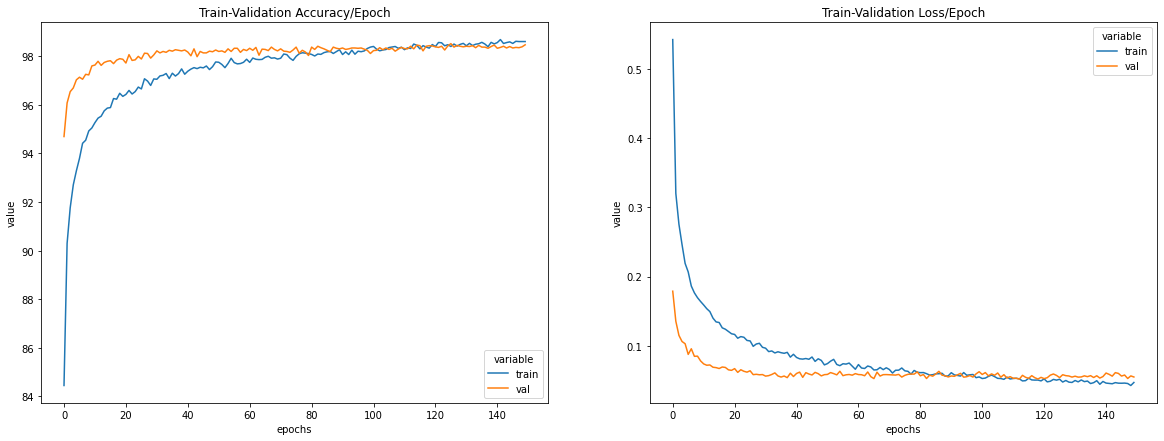

In [94]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Validation Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Validation Loss/Epoch')

### Save the model for future use

In [95]:
torch.save(model.state_dict(),'tensor.pt')

# reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# load the model to predict the label
# TODO: load the model and make a prediction
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()